<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_09_class_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load & Preprocess Data

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from data_utils import (load_data_from_url, clean_column_names, remove_id_column,
                        rename_columns, convert_categorical, preprocess_data, split_data, plot_class_distribution,
                        create_preprocessing_pipeline, add_model_to_pipeline, evaluate_model,
                        hyperparameter_tuning)
from resampling_utils import evaluate_model, aggregate_reports, extract_key_metrics, plot_key_metrics

# Define your parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'


# Load and Preprocess Data
data = preprocess_data(url, categorical_columns)

# Check if data is loaded and preprocessed correctly
if data is not None:
    # Split the data
    X_train, X_test, y_train, y_test = split_data(data, target=target)

    # Define preprocessing steps for numerical and categorical columns
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()

    # Create preprocessing pipeline
    pipeline = create_preprocessing_pipeline(numeric_features, categorical_features)
else:
    print("Data preprocessing failed. Please check the URL and preprocessing steps.")

Preprocessing pipeline created successfully.


#### Class Imbalance

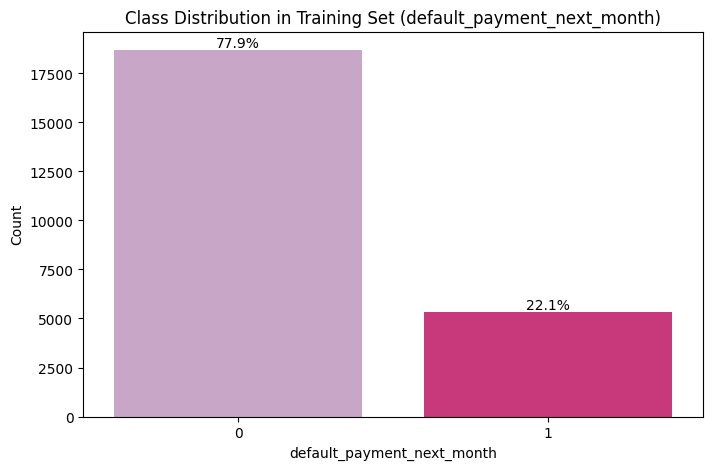

In [15]:
plot_class_distribution(y_train, target)

### Resample Data & Save Metrics

In [50]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Define the key metrics and classes you want to focus on
desired_metrics = ['recall', 'f1-score']
desired_classes = ['0', '1', 'macro avg']

# Initialize an empty list to store all reports
all_reports = []

# Logistic Regression with SMOTE
model = LogisticRegression(max_iter=500, random_state=42)
smote = SMOTE(random_state=42)
pipeline_with_smote = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('smote', smote),
    ('model', model)
])
pipeline_with_smote.fit(X_train, y_train)
y_pred_smote = pipeline_with_smote.predict(X_test)
report_smote = evaluate_model(y_test, y_pred_smote, "Logistic Regression with SMOTE")
all_reports = aggregate_reports(all_reports, report_smote)

# Logistic Regression with Undersampling
undersample = RandomUnderSampler(random_state=42)
pipeline_with_undersample = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('undersample', undersample),
    ('model', model)
])
pipeline_with_undersample.fit(X_train, y_train)
y_pred_undersample = pipeline_with_undersample.predict(X_test)
report_undersample = evaluate_model(y_test, y_pred_undersample, "Logistic Regression with Undersampling")
all_reports = aggregate_reports(all_reports, report_undersample)

# RandomForest with SMOTE
rf_model = RandomForestClassifier(random_state=42)
pipeline_with_rf_smote = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('smote', smote),
    ('model', rf_model)
])
pipeline_with_rf_smote.fit(X_train, y_train)
y_pred_rf_smote = pipeline_with_rf_smote.predict(X_test)
report_rf_smote = evaluate_model(y_test, y_pred_rf_smote, "RandomForest with SMOTE")
all_reports = aggregate_reports(all_reports, report_rf_smote)

# RandomForest with Undersampling
pipeline_with_rf_undersample = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('undersample', undersample),
    ('model', rf_model)
])
pipeline_with_rf_undersample.fit(X_train, y_train)
y_pred_rf_undersample = pipeline_with_rf_undersample.predict(X_test)
report_rf_undersample = evaluate_model(y_test, y_pred_rf_undersample, "RandomForest with Undersampling")
all_reports = aggregate_reports(all_reports, report_rf_undersample)

# Extract and display the key metrics
key_metrics_df = extract_key_metrics(all_reports, desired_metrics, desired_classes)

Classification Report for Logistic Regression with SMOTE:

              precision    recall  f1-score   support

           0       0.87      0.68      0.76      4673
           1       0.36      0.63      0.46      1327

    accuracy                           0.67      6000
   macro avg       0.61      0.66      0.61      6000
weighted avg       0.76      0.67      0.70      6000

Classification Report for Logistic Regression with Undersampling:

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      4673
           1       0.37      0.63      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000

Classification Report for RandomForest with SMOTE:

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      4673
           1       0.55      0.47      0.51      1327

    

### PLot Key Metrics

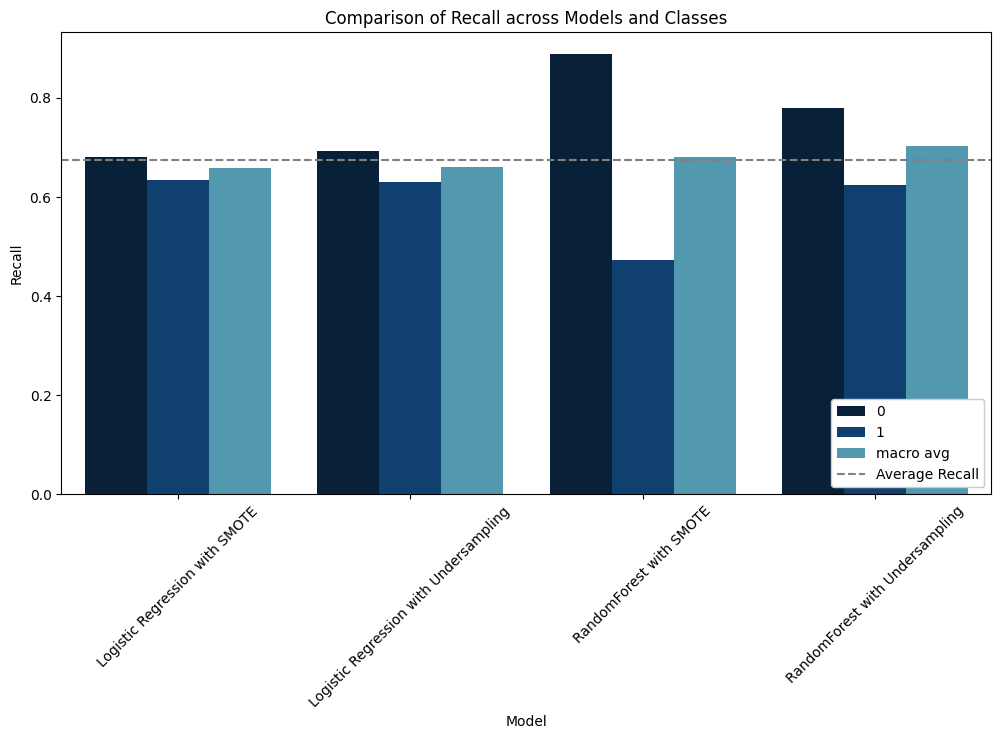

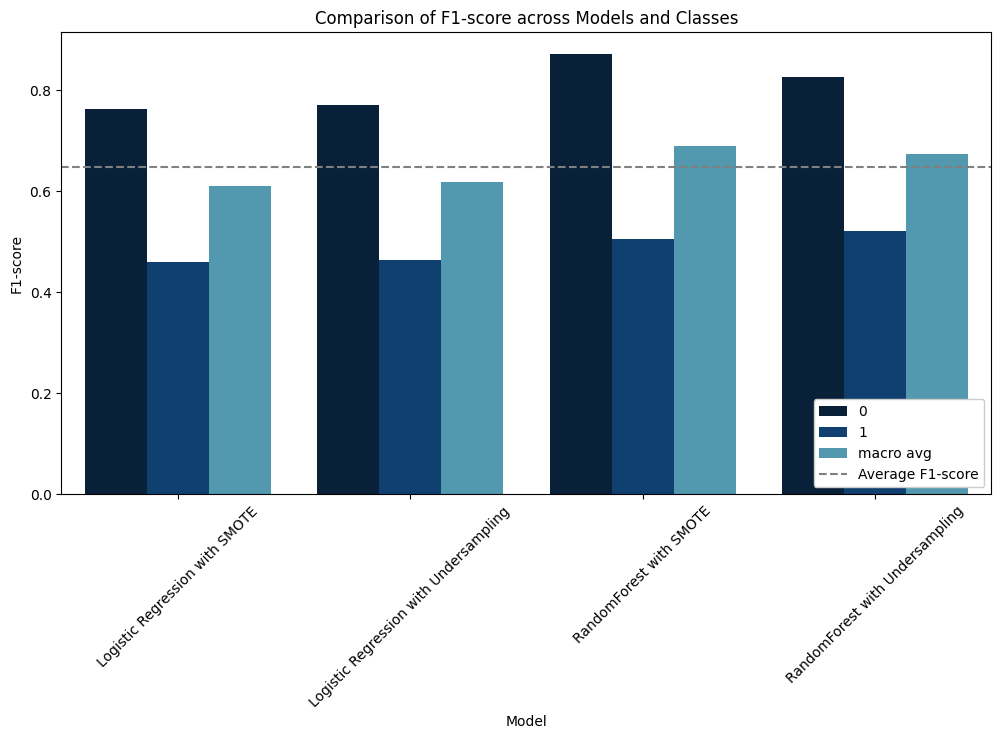

In [73]:
# Assuming `key_metrics_df` is the DataFrame with the extracted key metrics
plot_key_metrics(key_metrics_df, desired_metrics, desired_classes)

### Analyze Results

#### Key Metrics:
1. **Recall for Class 1**: This is our primary priority.
2. **Macro Average F1-Score**: We also aim to keep this high.

1. **Best Recall for Class 1**: Logistic Regression with SMOTE (0.634514) narrowly outperforms Logistic Regression with Undersampling (0.629239). However, both logistic regression models perform significantly better than the RandomForest models in terms of recall for class 1.
   
2. **Best Macro Average F1-Score**: RandomForest with SMOTE (0.688916) has the highest macro average F1-score, followed by RandomForest with Undersampling (0.673372). However, both RandomForest models perform worse in recall for class 1 compared to Logistic Regression models.

### Recommendations:

1. **Priority on Recall for Class 1**: If recall for class 1 is the absolute priority, Logistic Regression with SMOTE is the best option, closely followed by Logistic Regression with Undersampling.
   
2. **Balancing Recall and Macro Average F1-Score**: If balancing recall for class 1 and maintaining a higher macro average F1-score is important, Logistic Regression with Undersampling might be a better choice due to its slightly better macro average metrics compared to Logistic Regression with SMOTE, while still maintaining a competitive recall for class 1.

3. **RandomForest Models**: While RandomForest models have higher macro average scores, their performance in recall for class 1 is significantly lower, making them less suitable if recall for class 1 is the top priority.

### Final Recommendation:

Given the priority on recall for class 1 and the need to maintain a high F1 macro score, **Logistic Regression with SMOTE** is the recommended model, as it provides the best recall for class 1 while still maintaining a reasonable macro average F1-score.

### Class Weights

In [ ]:
# Logistic Regression with class weights
model_with_weights = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
pipeline_with_weights = add_model_to_pipeline(pipeline, model_with_weights)

# Fit the pipeline with class weights
pipeline_with_weights.fit(X_train, y_train)

# Transform the test data and evaluate the model
evaluate_model(pipeline_with_weights, X_test, y_test)


### Evaluation

In [ ]:
# Compare the performance of different methods
# You can store the results of each method and plot them for comparison

# Example: Logistic Regression without balancing
print("Logistic Regression without balancing")
evaluate_model(pipeline_with_model, X_test, y_test)

# Logistic Regression with SMOTE
print("Logistic Regression with SMOTE")
evaluate_model(pipeline_with_smote, X_test, y_test)

# Logistic Regression with undersampling
print("Logistic Regression with undersampling")
evaluate_model(pipeline_with_undersample, X_test, y_test)

# Logistic Regression with class weights
print("Logistic Regression with class weights")
evaluate_model(pipeline_with_weights, X_test, y_test)


#### Write Data Utils Script

In [18]:
# function to write script
script_content = r'''

# data_utils.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Load the dataset from a URL
def load_data_from_url(url):
    """
    Load the dataset from a specified URL.

    Parameters:
    - url: str, URL of the dataset

    Returns:
    - pd.DataFrame, loaded dataset
    """
    try:
        df = pd.read_excel(url, header=1)
    except Exception as e:
        print(f"Error loading data from URL: {e}")
        return None
    return df

# Clean column names
def clean_column_names(df):
    """
    Clean the column names by converting to lowercase and replacing spaces with underscores.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with cleaned column names
    """
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    """
    Remove the 'id' column if it exists.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe without 'id' column
    """
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    """
    Rename specific columns based on a predefined dictionary.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with renamed columns
    """
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    """
    Convert specified columns to categorical type.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, dataframe with converted columns
    """
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    """
    Split the data into training and testing sets.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - target: str, name of the target column

    Returns:
    - tuple, (X_train, X_test, y_train, y_test)
    """
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

def preprocess_data(url, categorical_columns):
    """
    Load and preprocess the data.

    Parameters:
    - url: str, URL of the dataset
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, preprocessed data
    """
    # Load the dataset
    data = load_data_from_url(url)

    if data is None:
        return None

    # Clean column names
    data = clean_column_names(data)

    # Remove the 'id' column
    data = remove_id_column(data)

    # Rename columns
    data = rename_columns(data)

    # Convert specified columns to categorical type
    data = convert_categorical(data, categorical_columns)

    return data

# Plot class balance in the training set with ratio annotations
def plot_class_distribution(y_train, target):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='PuRd')
    plt.title(f'Class Distribution in Training Set ({target})')
    plt.xlabel(target)
    plt.ylabel('Count')
    plt.legend([],[], frameon=False)  # Turn off the legend

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


def create_preprocessing_pipeline(numeric_features, categorical_features):
    """
    Create a preprocessing pipeline for numeric and categorical features.

    Parameters:
    - numeric_features: list of str, names of numeric features
    - categorical_features: list of str, names of categorical features

    Returns:
    - sklearn.pipeline.Pipeline, the complete preprocessing pipeline
    """
    # Define the transformers for numerical and categorical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine the transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Create the full pipeline with preprocessing and a placeholder for the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
        # You can add your model here, e.g., ('model', RandomForestClassifier())
    ])

    print("Preprocessing pipeline created successfully.")
    return pipeline

def add_model_to_pipeline(pipeline, model):
    """
    Add a model to the preprocessing pipeline.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the preprocessing pipeline
    - model: sklearn estimator, the model to add to the pipeline

    Returns:
    - sklearn.pipeline.Pipeline, the complete pipeline with the model added
    """
    return Pipeline(steps=pipeline.steps + [('model', model)])

def evaluate_model(pipeline, X_test, y_test):
    """
    Evaluate the model using the test data.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - X_test: pd.DataFrame or np.ndarray, the test features
    - y_test: pd.Series or np.ndarray, the test labels

    Returns:
    - np.ndarray, the predicted labels
    """
    y_pred = pipeline.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    # print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return y_pred

def hyperparameter_tuning(pipeline, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - param_grid: dict, the parameter grid for GridSearchCV
    - X_train: pd.DataFrame or np.ndarray, the training features
    - y_train: pd.Series or np.ndarray, the training labels

    Returns:
    - sklearn estimator, the best estimator found by GridSearchCV
    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Parameters:\n", grid_search.best_params_)
    return grid_search.best_estimator_

'''

# Write the script to a file
with open("data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_utils.py")

# reload script to make function available for use
import importlib
import data_utils
importlib.reload(data_utils)

from data_utils import (load_data_from_url, clean_column_names, remove_id_column,
                        rename_columns, convert_categorical, preprocess_data, split_data, plot_class_distribution,
                        create_preprocessing_pipeline, add_model_to_pipeline, evaluate_model,
                        hyperparameter_tuning)

Script successfully written to data_utils.py


#### Write Resampling Utils Script

In [74]:
script_content = r'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate the model and return the classification report as a dictionary.

    Parameters:
    - y_true: array-like, true labels
    - y_pred: array-like, predicted labels
    - model_name: str, name of the model

    Returns:
    - dict, classification report dictionary
    """
    report_dict = classification_report(y_true, y_pred, output_dict=True)

    # Print the classification report
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred))

    # Add model name to the dictionary
    report_dict['model'] = model_name

    return report_dict

def aggregate_reports(reports_list, new_report):
    """
    Aggregate classification reports into a list.

    Parameters:
    - reports_list: list, list of classification reports
    - new_report: dict, new classification report to add

    Returns:
    - list, updated list of classification reports
    """
    reports_list.append(new_report)
    return reports_list

def extract_key_metrics(reports_list, metrics, classes):
    """
    Extract key metrics from the aggregated classification reports.

    Parameters:
    - reports_list: list, list of classification reports
    - metrics: list of str, metrics to extract
    - classes: list of str, classes to include in the comparison

    Returns:
    - pd.DataFrame, DataFrame with the selected metrics
    """
    extracted_metrics = []

    for report in reports_list:
        model_name = report['model']
        for cls in classes:
            for metric in metrics:
                metric_value = report[cls][metric]
                extracted_metrics.append({
                    'model': model_name,
                    'class': cls,
                    'metric': metric,
                    'value': metric_value
                })

    return pd.DataFrame(extracted_metrics)

def plot_key_metrics(metrics_df, metrics, classes):
    """
    Plot key metrics from the aggregated classification reports.

    Parameters:
    - metrics_df: pd.DataFrame, DataFrame containing the extracted metrics
    - metrics: list of str, metrics to plot (e.g., ['recall', 'f1-score'])
    - classes: list of str, classes to include in the plot

    Returns:
    - None
    """
    primary_metric = metrics[0]
    secondary_metric = metrics[1] if len(metrics) > 1 else None

    for metric in metrics:
        plt.figure(figsize=(12, 6))

        # Filter the DataFrame for the current metric
        metric_df = metrics_df[metrics_df['metric'] == metric]

        # Plot the bar plot
        sns.barplot(data=metric_df, x='model', y='value', hue='class', palette='ocean')
        plt.title(f'Comparison of {metric.capitalize()} across Models and Classes')
        plt.xlabel('Model')
        plt.ylabel(metric.capitalize())
        plt.legend(title='Class', loc='lower right', framealpha=1.0)
        plt.xticks(rotation=45)

        # Calculate and plot the average line for the primary and secondary metrics
        if metric == primary_metric or metric == secondary_metric:
            avg_metric_value = metric_df['value'].mean()
            plt.axhline(avg_metric_value, color='0.5', linestyle='--', label=f'Average {metric.capitalize()}')
            plt.legend(loc='lower right', framealpha=1.0)

        plt.show()

'''

# Write the script to a file
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to resampling_utils.py")

# Reload script to make functions available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)

from resampling_utils import evaluate_model, aggregate_reports, extract_key_metrics, plot_key_metrics


Script successfully written to resampling_utils.py
